# Joint analysis of single-cell and spatial data using SpatialVAE

In this example we will demonstrate how to use the `SpatialVAE` model (`scvi.model.SCVI` equipped with the spatial loss) to jointly analyze single-cell and spatial data. Specifically, we will start with a pretrained single-cell-only SCVI model and transfer the cell type labels to Slide-seqV2 spatial data.

- The human prostate spatial transcriptomics data of [Hirz T et al. (2023)](https://www.nature.com/articles/s41467-023-36325-2) can be downloaded from https://github.com/shenglinmei/ProstateCancerAnalysis.
- The single-cell RNA-seq dataset of [Tabula Sapiens](https://www.science.org/doi/10.1126/science.abl4896) and the pretrained SCVI model can be downloaded from https://huggingface.co/scvi-tools/tabula-sapiens-prostate-scvi.
- This notebook is modified to reflect latest updates of scvi-tools and the pretrained model. Original analysis described in the [Smoother paper (Su J et al. (2023))](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-03138-x) and the corresponding model and data can be found in the [archived repository](https://github.com/JiayuSuPKU/Smoother_paper/blob/main/scripts/prostate_ref_mapping/).

In [1]:
import numpy as np
import pynndescent
import torch
import pandas as pd

import matplotlib.pyplot as plt
from plotnine import *

from smoother import SpatialWeightMatrix, SpatialLoss
from smoother.models.reduction import SpatialVAE

import scvi
from scvi.hub import HubModel
import scanpy as sc
import anndata

In [2]:
DATA_DIR = "./prostate_ref_mapping/data/"
RES_DIR = "./prostate_ref_mapping/results/"

## Check the single-cell reference and the pretrained prostate-scvi model

The Hugging Face SCVI prostate model has been updated (as of commit 04a818e). Previously the model was attached with pancreatic cells that need to be replaced with the correct single-cell reference. Note also that the single-cell training data has also been updated to exclude cells from 'TSP14'. This new reference data can be downloaded from [here](https://zenodo.org/records/7608635/files/Prostate_training_data.h5ad) and is different from the [archived data](https://zenodo.org/records/10223862) used in the Smoother paper. 

In [3]:
# download model and the single-cell Tabula Sapiens reference
tsp_scvi = HubModel.pull_from_huggingface_hub(
    repo_name="scvi-tools/tabula-sapiens-prostate-scvi",
    cache_dir=f"{DATA_DIR}/tabula-sapiens-prostate-scvi",
    revision="main",
)
model_ref = tsp_scvi.model

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

INFO     Loading model...                                                                                          
INFO     File                                                                                                      
         ./prostate_ref_mapping/data//tabula-sapiens-prostate-scvi/models--scvi-tools--tabula-sapiens-prostate-scvi
         /snapshots/04a818e709443086b9d390a1818788edaefb4849/model.pt already downloaded                           


/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.


In [4]:
# load the full prostate sc reference data downloaded from
# https://zenodo.org/records/7608635/files/Prostate_training_data.h5ad
ref_dir = f"{DATA_DIR}/Prostate_training_data.h5ad"
scref = anndata.read_h5ad(ref_dir)

# attach the full data to the model
scvi.model.SCVI.prepare_query_anndata(scref, model_ref)
model_ref = scvi.model.SCVI.load_query_data(
    scref,
    model_ref
)
model_ref.is_trained_ = True

INFO     Found 100.0% reference vars in query data.                                                                


/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.


### UMAP visualization

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/umap/distances.py:108

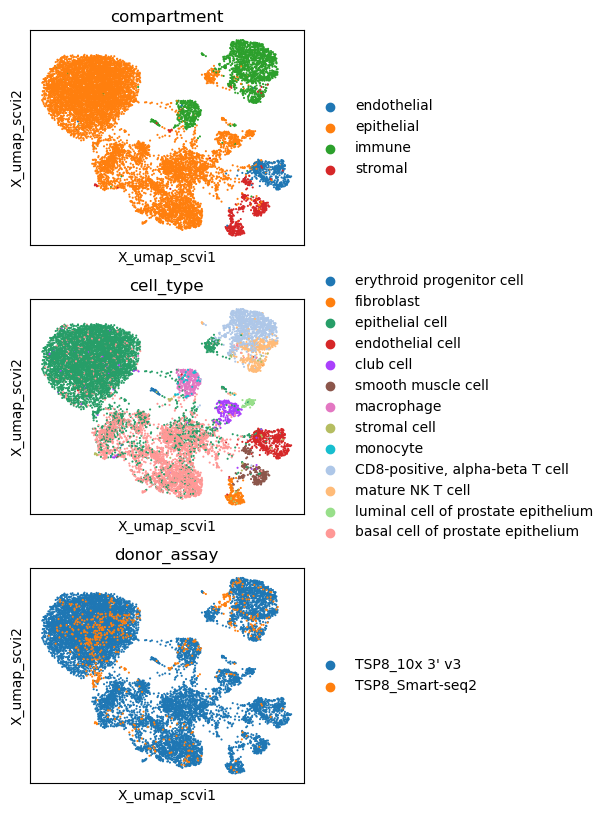

In [5]:
scref.obsm['X_scvi'] = model_ref.get_latent_representation(scref)
sc.pp.neighbors(scref, use_rep="X_scvi")
sc.tl.umap(scref)
scref.obsm["X_umap_scvi"] = scref.obsm['X_umap'].copy()

with plt.rc_context({"figure.figsize": (3, 3), 'savefig.bbox': 'tight'}):
    sc.pl.embedding(
        scref, basis='X_umap_scvi', ncols = 1,
        color=['compartment', 'cell_type', 'donor_assay']
    )

## Finetuning the model on Slide-seqV2 spatial prostate data

### Load data from healthy patient HP1

Per-sample spatial data is deposited at [the archived dataset](https://zenodo.org/records/10223862) under "prostate_ref_mapping". Raw data from the [original publication (Hirz T et al. (2023))](https://www.nature.com/articles/s41467-023-36325-2) can be downloaded from https://github.com/shenglinmei/ProstateCancerAnalysis.

In [6]:
st = sc.read_h5ad(f"{DATA_DIR}/ST_HP1.h5ad")
st.layers['raw'] = st.X.copy()
st.obsm['spatial'] = st.obs[['xcoord', 'ycoord']].values
st.obs['donor_assay'] = st.obs['batch']
st.obs['cell_ontology_class'] = "unlabeled"

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


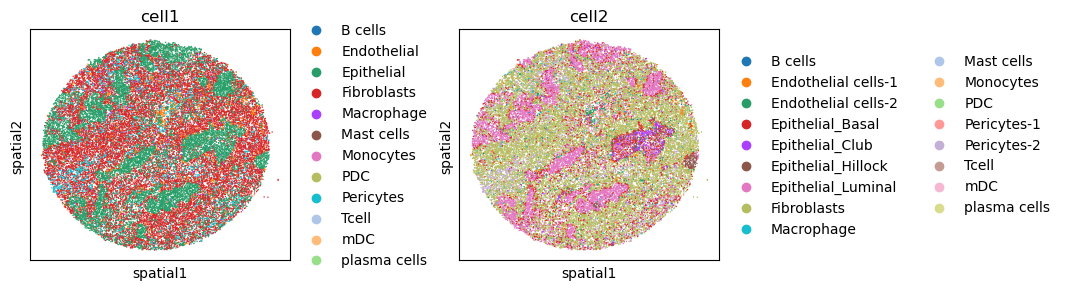

In [7]:
# visualize the annotation provided by Hirz T et al.
with plt.rc_context({"figure.figsize": (3, 3), 'savefig.bbox': 'tight'}):
    sc.pl.embedding(
        st, basis='spatial', ncols = 2, wspace = 0.5,
        color=['cell1', 'cell2']
    )

### (Optional) RNA-only finetuning

Using the conventional SCVI workflow corresponds to an RNA-only finetuning step since it ignores spatial information altogether. We will see why this is suboptimal later. This step can be skipped in practical applications.

In [8]:
st_rna = scvi.model.SCVI.prepare_query_anndata(st, model_ref, inplace=False)

INFO     Found 87.875% reference vars in query data.                                                               


/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.


Here we set `unfrozen=True` to fit the ST data as much as possible.

In [9]:
model_q = scvi.model.SCVI.load_query_data(
    st_rna,
    model_ref,
    unfrozen=True,
)

In [10]:
model_q.train(max_epochs=100, accelerator='cpu', plan_kwargs=dict(weight_decay=0.0))

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


Epoch 100/100: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [07:51<00:00,  5.06s/it, v_num=1, train_loss_step=646, train_loss_epoch=606]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [07:51<00:00,  4.72s/it, v_num=1, train_loss_step=646, train_loss_epoch=606]


In [11]:
dir_path = f"{RES_DIR}/scvi_st_finetuned_unfrozen/"
model_q.save(dir_path, overwrite=True)

#### Reload the finetuned model

In [12]:
dir_path = f"{RES_DIR}/scvi_st_finetuned_unfrozen/"
model_q = scvi.model.SCVI.load(dir_path, st_rna)

INFO     File ./prostate_ref_mapping/results//scvi_st_finetuned_unfrozen/model.pt already downloaded               


#### UMAP visualization

In [13]:
st.obsm["X_scvi"] = model_q.get_latent_representation()
sc.pp.neighbors(st, use_rep="X_scvi")
sc.tl.leiden(st, key_added='leiden_scvi')
sc.tl.umap(st)
st.obsm["X_umap_scvi"] = st.obsm['X_umap'].copy()

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


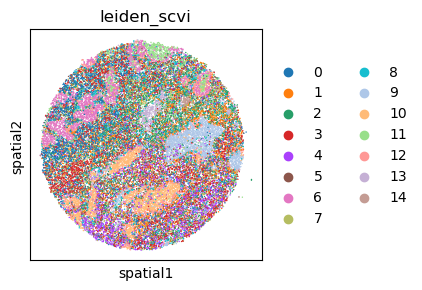

In [14]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(st, basis='spatial', color = ['leiden_scvi'])

### SpatialVAE finetuning

#### Generate the spatial loss function

We first preprocess the ST data to get the expression needed for weights scaling.

In [15]:
st_sp = st.copy()

sc.pp.normalize_total(st_sp, target_sum=1e4)
sc.pp.log1p(st_sp)
st_sp.layers['log1p'] = st_sp.X.copy()
sc.pp.highly_variable_genes(
    st_sp, subset=False, n_top_genes=2000, layer="log1p"
)

# remember to switch back to the raw counts data
st_sp.X = st_sp.layers['raw']

Then generate the spatial neighborhood graph and the corresponding loss function.

In [16]:
y = st_sp.layers['log1p'][:, st_sp.var['highly_variable']].toarray()
y = torch.tensor(y).T
coords = st_sp.obsm['spatial']

# generate the spatial neighborhood graph
weights = SpatialWeightMatrix()
weights.calc_weights_knn(coords)
weights.scale_by_expr(y)

# prepare spatial loss
sp_loss = SpatialLoss('icar', weights, rho=0.99, standardize_cov=False)

Number of spots: 29278. Average number of neighbors per spot:  5.13.
Number of spots: 29278. Average number of neighbors per spot:  5.14.


#### Transfer from the RNA-only SCVI model and train

Now we can convert a regular RNA-only SCVI model into a spatially aware one. The baseline model can either be the pretrained single-cell model `model_ref`, or the RNA-only finetuned one `model_q`. Here we choose the latter to illsutrate the behavior induced by spatial regularization. 

In [17]:
st_sp = scvi.model.SCVI.prepare_query_anndata(st_sp, model_q, inplace=False)

INFO     Found 87.875% reference vars in query data.                                                               


/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.


Again, unfroze the model to allow parameter adaptation under the spatial loss.

In [18]:
model_sp = SpatialVAE.from_rna_model(
    st_sp, model_q, 
    spatial_loss=sp_loss, lambda_spatial_loss=0.01,
    unfrozen=True,
)

INFO     Found 100.0% reference vars in query data.                                                                


In [19]:
model_sp.train(max_epochs=100, accelerator='cpu', plan_kwargs=dict(weight_decay=0.0))

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 100/100: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [08:31<00:00,  4.99s/it, v_num=1, train_loss_step=624, train_loss_epoch=624]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|████████████████████████████████████████████████████████████████████████| 100/100 [08:31<00:00,  5.11s/it, v_num=1, train_loss_step=624, train_loss_epoch=624]


In [20]:
dir_path = f"{RES_DIR}/spvae_st_finetuned_unfrozen/"
model_sp.save(dir_path, overwrite=True)

#### Reload the trained SpatialVAE model

In [21]:
st_sp = scvi.model.SCVI.prepare_query_anndata(st_sp, model_q, inplace=False)
dir_path = dir_path = f"{RES_DIR}/spvae_st_finetuned_unfrozen/"
model_sp = SpatialVAE.load(dir_path, st_sp)

INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ./prostate_ref_mapping/results//spvae_st_finetuned_unfrozen/model.pt already downloaded              


#### UMAP visualization

In [22]:
st.obsm['X_spvae'] = model_sp.get_latent_representation()
sc.pp.neighbors(st, use_rep="X_spvae")
sc.tl.leiden(st, key_added='leiden_spvae', resolution=0.5)
sc.tl.umap(st)
st.obsm['X_umap_spvae'] = st.obsm['X_umap'].copy()

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


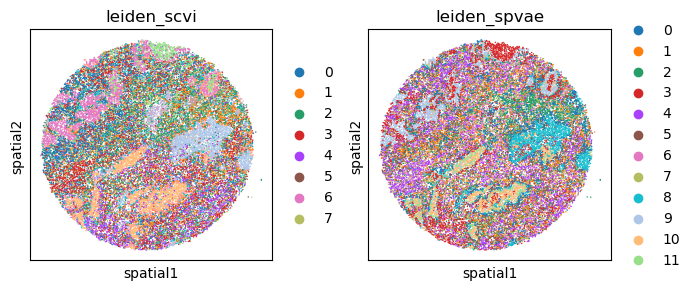

In [23]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(st, basis='spatial', color=['leiden_scvi', 'leiden_spvae'], ncols=2)

#### Spatial Loss diagnosis

In [24]:
# RNA-only fine-tuning
df_loss_q = pd.DataFrame(
    {k:model_q.history[k].values.squeeze().astype(float)
     for k in ['reconstruction_loss_train', 'kl_local_train', 'kl_global_train']}
)
df_loss_q.reset_index(inplace=True)

# spatial fine-tuning
df_loss_sp = pd.DataFrame(
    {k:model_sp.history[k].values.squeeze().astype(float)
     for k in ['reconstruction_loss_train', 'kl_local_train', 'kl_global_train']}
)
df_loss_sp.reset_index(inplace=True)
df_loss_sp['index'] += 100

# overall loss
df_loss = pd.concat([df_loss_q, df_loss_sp])
df_loss['phase'] = pd.Categorical(
    np.repeat(['RNA-only fine-tuning', 'Spatial fine-tuning'], 100),
    categories=['RNA-only fine-tuning', 'Spatial fine-tuning'],
    ordered=True
)

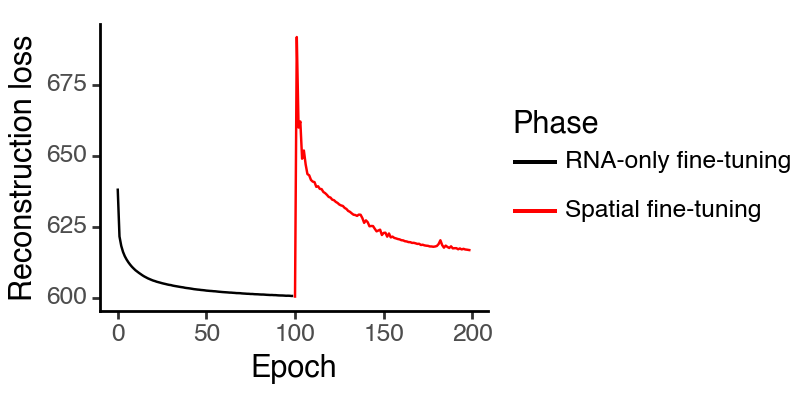

<Figure Size: (400 x 200)>

In [25]:
(
    ggplot(df_loss, aes(x = 'index', y = 'reconstruction_loss_train', color = 'phase')) +
        geom_line() + 
        labs(x = 'Epoch', y = 'Reconstruction loss', color = 'Phase') + 
        scale_color_manual(values={
            'RNA-only fine-tuning': 'black', 'Spatial fine-tuning': 'red'
        }) + 
        theme_classic() + 
        theme(figure_size=(4,2))
)

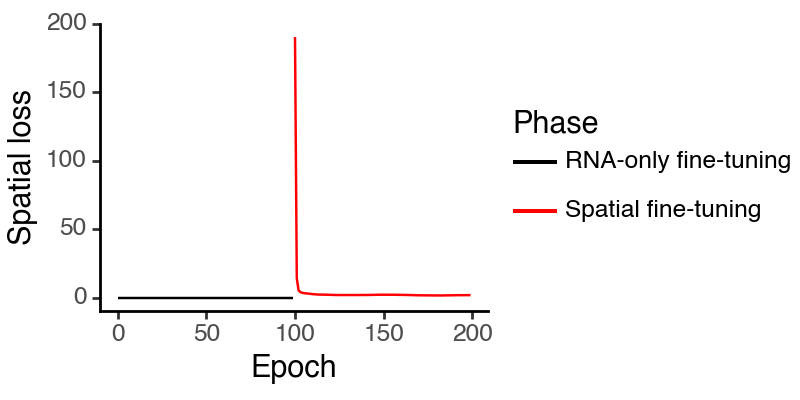

<Figure Size: (400 x 200)>

In [26]:
(
    ggplot(df_loss, aes(x = 'index', y = 'kl_global_train', color = 'phase')) +
        geom_line() + 
        labs(x = 'Epoch', y = 'Spatial loss', color = 'Phase') + 
        scale_color_manual(values={
            'RNA-only fine-tuning': 'black', 'Spatial fine-tuning': 'red'
        }) + 
        theme_classic() + 
        theme(figure_size=(4,2))
)

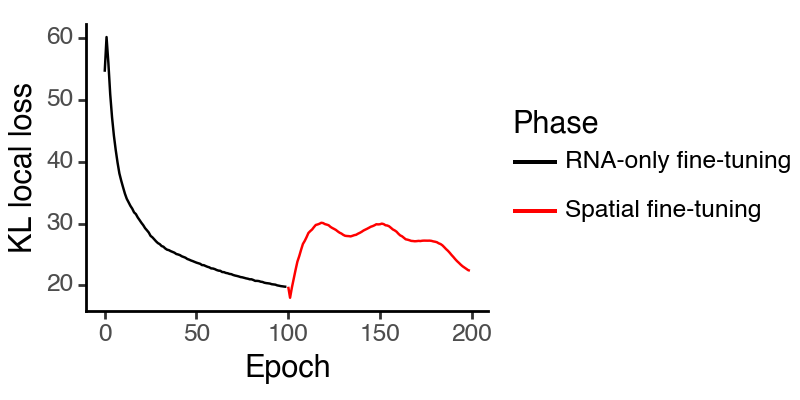

<Figure Size: (400 x 200)>

In [27]:
(
    ggplot(df_loss, aes(x = 'index', y = 'kl_local_train', color = 'phase')) +
        geom_line() + 
        labs(x = 'Epoch', y = 'KL local loss', color = 'Phase') + 
        scale_color_manual(values={
            'RNA-only fine-tuning': 'black', 'Spatial fine-tuning': 'red'
        }) + 
        theme_classic() + 
        theme(figure_size=(4,2))
)

In [28]:
sp_loss(torch.tensor(st.obsm['X_scvi'].T)), sp_loss(torch.tensor(st.obsm['X_spvae'].T))

(tensor(0.6101), tensor(0.0046))

## Extracting joint embeddings of the single-cell and spatial data

In [29]:
# concatenate single-cell reference and the spatial data
adata_full = st_rna.concatenate(scref, batch_key='tech', batch_categories=['ST', 'SC'])

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.


Note that there are significant technical batch effects between different sequencing platforms. In particular, Slide-seqV2 data is quite sparse. We will see later that the spatial loss helps mitigate the challenge, potentially via directing the model to focus on spatially consistent features over batch-specific technical noise.

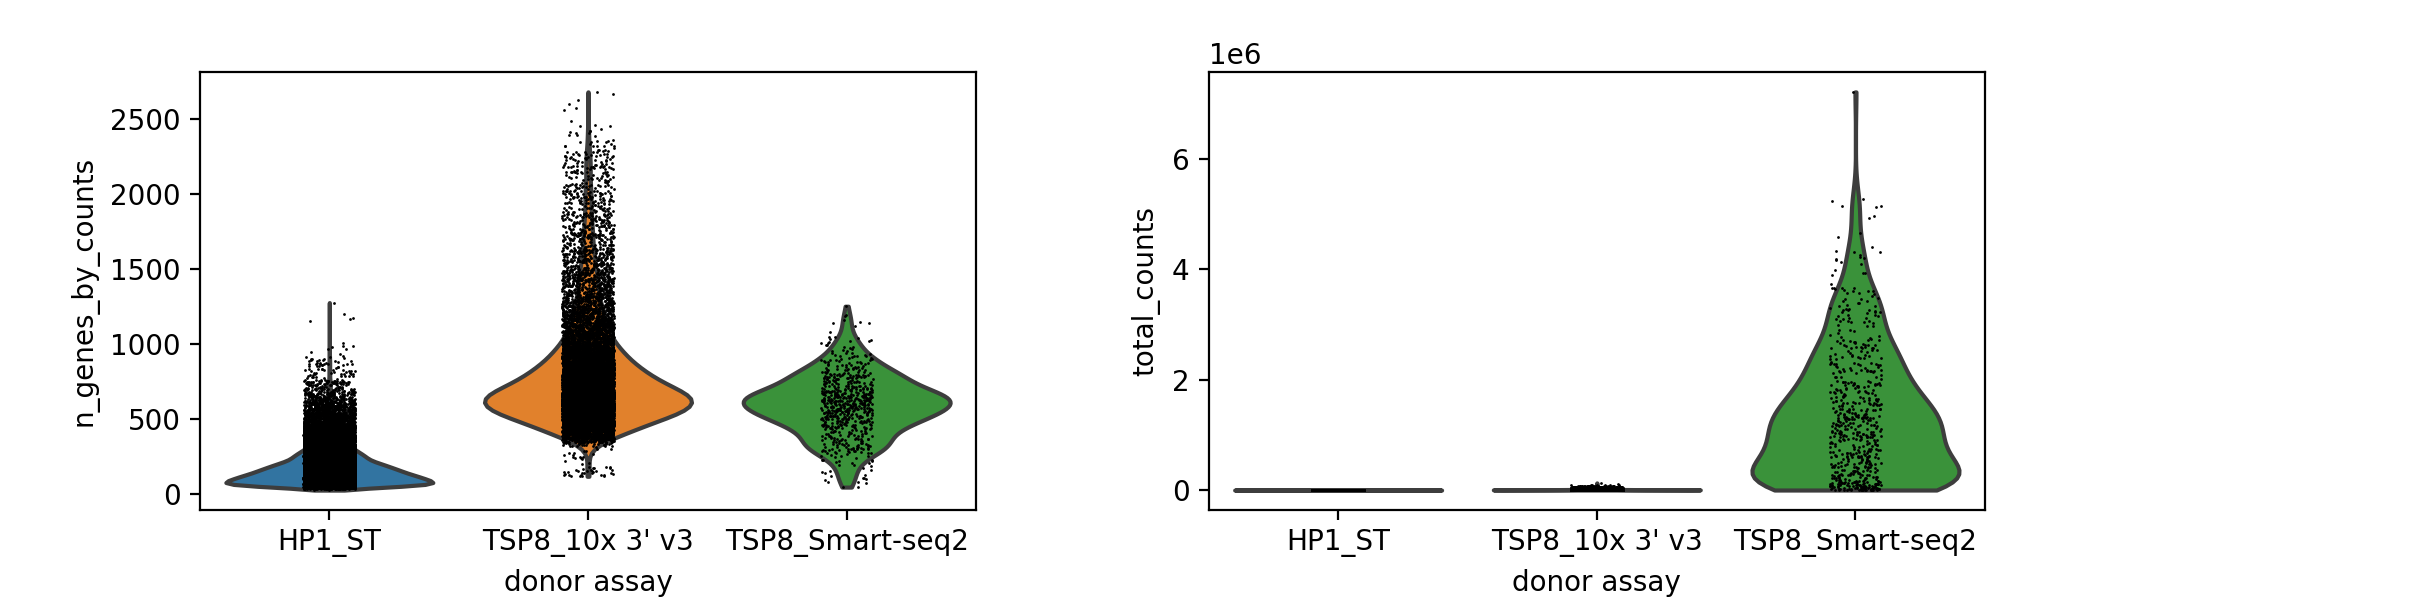

In [30]:
sc.pp.calculate_qc_metrics(adata_full, inplace = True)

with plt.rc_context({"figure.figsize": (5, 3)}):
    sc.pl.violin(adata_full, ['n_genes_by_counts', 'total_counts'], groupby='donor_assay')

### RNA-only model representations

In [31]:
adata_full.obsm["X_scvi"] = model_q.get_latent_representation(adata_full)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


#### UMAP visualization

In [32]:
sc.pp.neighbors(adata_full, use_rep="X_scvi")
sc.tl.leiden(adata_full, key_added = 'leiden_scvi')
sc.tl.umap(adata_full)
adata_full.obsm['X_umap_scvi'] = adata_full.obsm['X_umap'].copy()

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


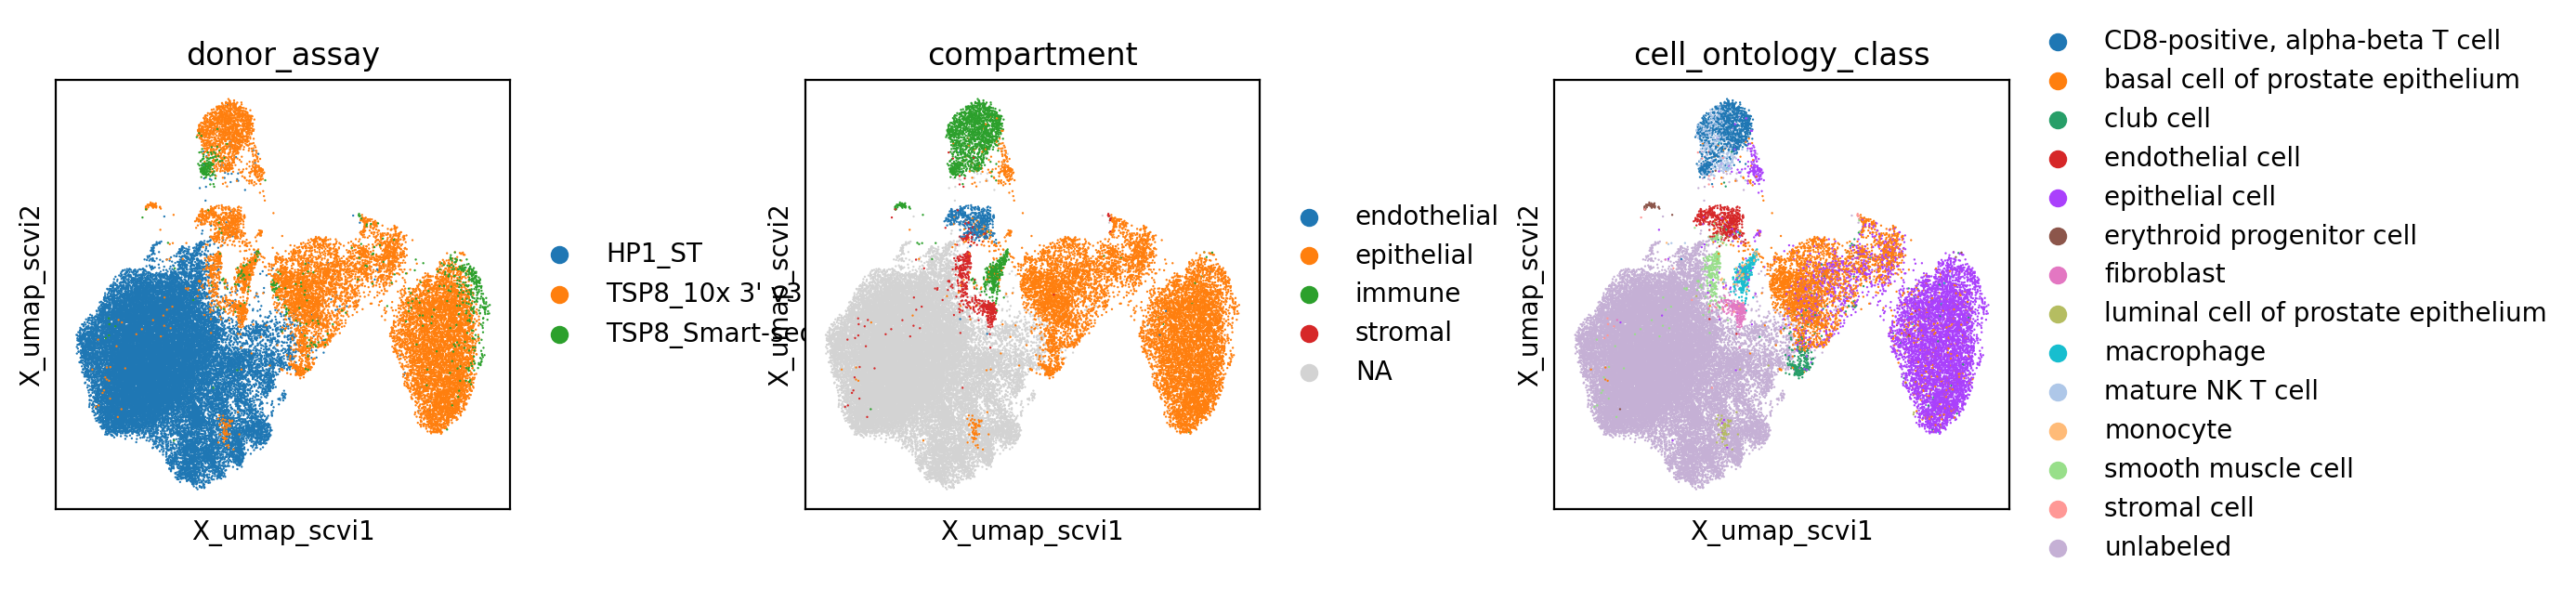

In [33]:
with plt.rc_context({"figure.figsize": (3, 3), 'savefig.bbox': 'tight'}):
    sc.pl.embedding(
        adata_full, basis='X_umap_scvi',
        color=['donor_assay', 'compartment', 'cell_ontology_class'], wspace=0.5
    )

### SpatialVAE model representations

In [34]:
adata_full_sp = st_sp.concatenate(scref, batch_key='tech', batch_categories=['ST', 'SC'])

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.


In [35]:
adata_full.obsm["X_spvae"] = model_sp.get_latent_representation(adata_full_sp)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


#### UMAP visualization

In [36]:
sc.pp.neighbors(adata_full, use_rep="X_spvae")
sc.tl.leiden(adata_full, key_added = 'leiden_spvae')
sc.tl.umap(adata_full)
adata_full.obsm['X_umap_spvae'] = adata_full.obsm['X_umap'].copy()

/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


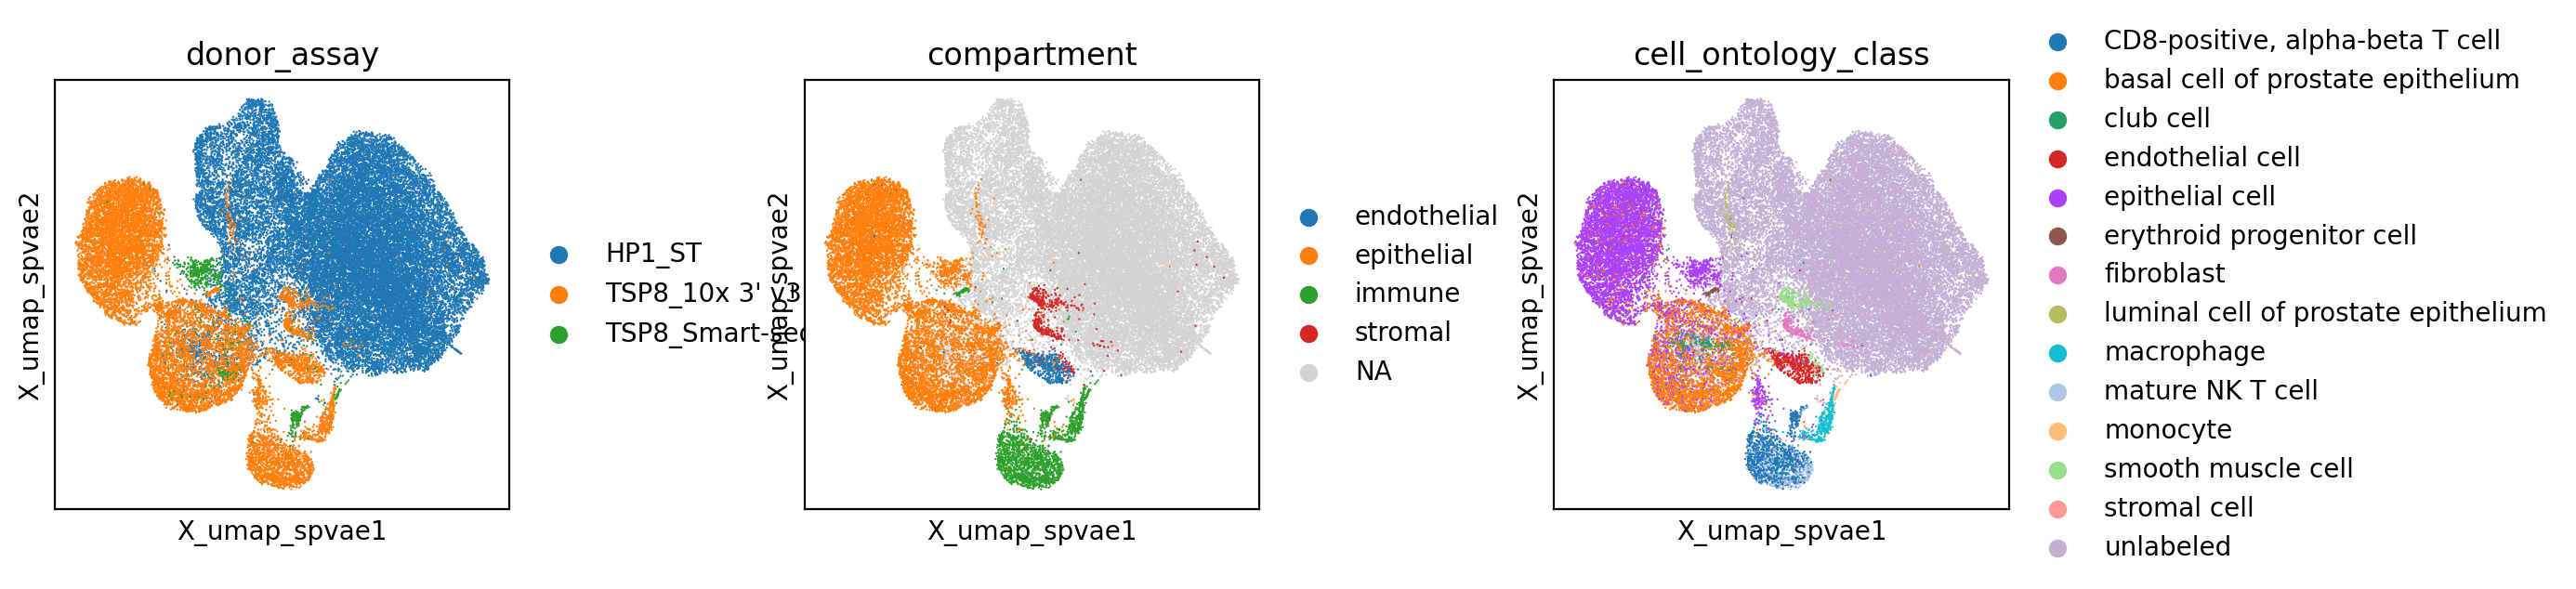

In [37]:
with plt.rc_context({"figure.figsize": (3, 3), 'savefig.bbox': 'tight'}):
    sc.pl.embedding(
        adata_full, basis='X_umap_spvae',
        color=['donor_assay', 'compartment', 'cell_ontology_class'], wspace=0.5
    )

### Transfer reference annotation to the spatial data

Having established the spatially aware joint embeddings, we now can transfer reference annotation from the Tabular Sapiens reference to the spatial prostate data. This reference mapping procedure is based on distance in the embedding space. See the SCVI [tutorial on querying the Human Lung Cell Atlas](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/query_hlca_knn.html) for details. 

In [38]:
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

#### From RNA-only SCVI representations

In [39]:
X_train = adata_full[adata_full.obs['tech'] == 'SC'].obsm['X_scvi']
ref_nn_index = pynndescent.NNDescent(X_train)
ref_nn_index.prepare()

query_data = adata_full[adata_full.obs['tech'] == 'ST'].obsm['X_scvi']
ref_neighbors, ref_distances = ref_nn_index.query(query_data)

In [40]:
# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(ref_distances_tilda, axis=1, keepdims=True)

# for each annotation level, get prediction and uncertainty
label_keys = ['free_annotation', 'compartment', 'cell_type']
for l in label_keys:
    ref_cats = scref.obs[l].cat.codes.to_numpy()[ref_neighbors]
    p, u = weighted_prediction(weights, ref_cats)
    p = np.asarray(scref.obs[l].cat.categories)[p]
    st.obs[l + "_pred_scvi"], st.obs[l + "_uncertainty_scvi"] = p, u

In [41]:
uncertainty_threshold = 0.2
for l in label_keys:
    mask = st.obs[l + "_uncertainty_scvi"] > 0.2
    print(f"{l}: {sum(mask)/len(mask)} unknown")
    st.obs[l + "_pred_scvi"].loc[mask] = "Unknown"

free_annotation: 0.4431996721087506 unknown
compartment: 0.1884691577293531 unknown
cell_type: 0.4398182935992896 unknown


/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_24944/2621080163.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


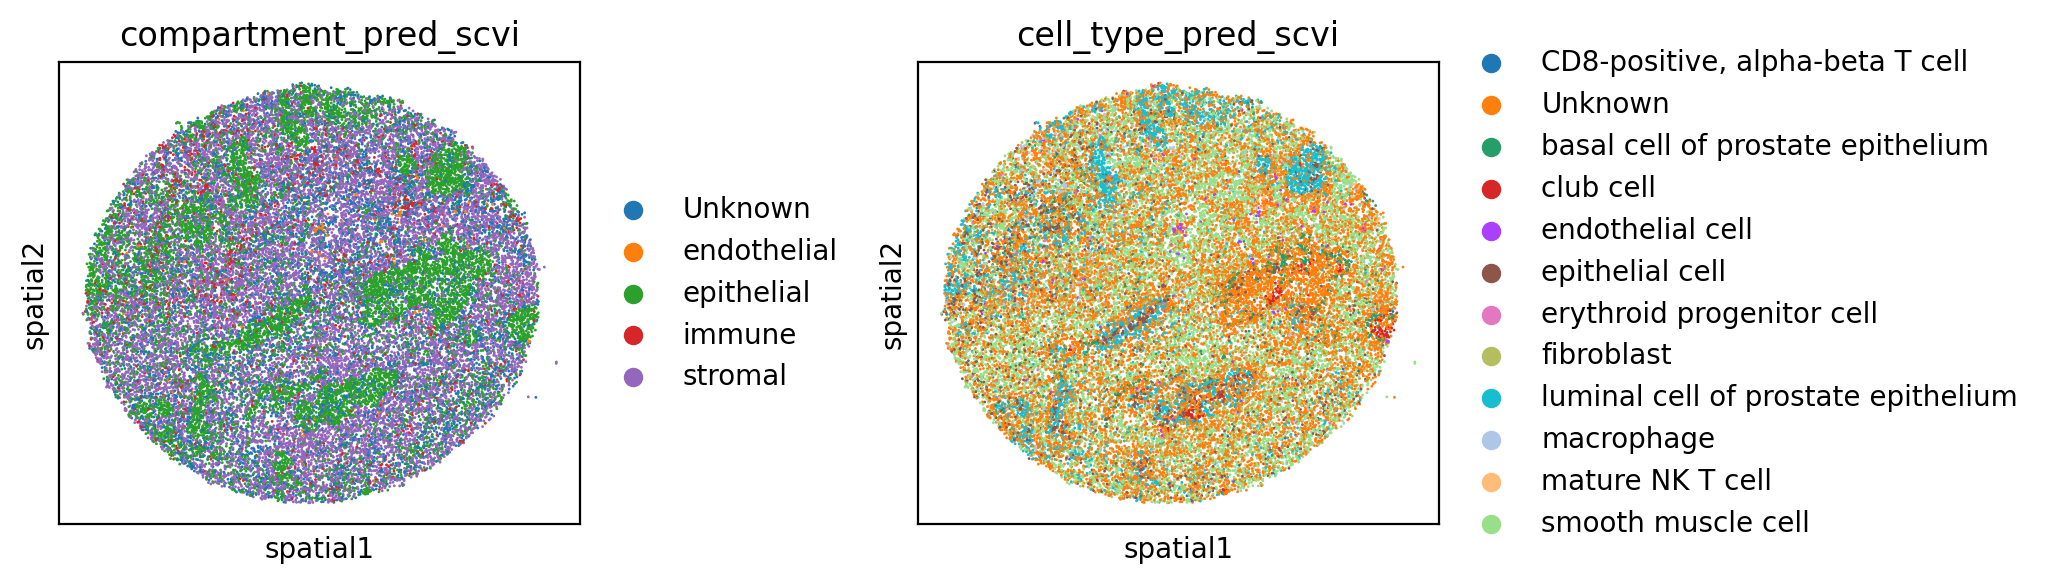

In [42]:
with plt.rc_context({"figure.figsize": (3, 3), 'savefig.bbox': 'tight'}):
    sc.pl.embedding(
        st, basis='spatial', ncols=2, wspace = 0.5,
        color=['compartment_pred_scvi', 'cell_type_pred_scvi']
    )

#### From SpatialVAE representations

In [43]:
X_train = adata_full[adata_full.obs['tech'] == 'SC'].obsm['X_spvae']
ref_nn_index = pynndescent.NNDescent(X_train)
ref_nn_index.prepare()

query_data = adata_full[adata_full.obs['tech'] == 'ST'].obsm['X_spvae']
ref_neighbors, ref_distances = ref_nn_index.query(query_data)

In [44]:
# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(ref_distances_tilda, axis=1, keepdims=True)


# for each annotation level, get prediction and uncertainty
label_keys = ['free_annotation', 'compartment', 'cell_type']
for l in label_keys:
    ref_cats = scref.obs[l].cat.codes.to_numpy()[ref_neighbors]
    p, u = weighted_prediction(weights, ref_cats)
    p = np.asarray(scref.obs[l].cat.categories)[p]
    st.obs[l + "_pred_spvae"], st.obs[l + "_uncertainty_spvae"] = p, u

In [45]:
uncertainty_threshold = 0.2
for l in label_keys:
    mask = st.obs[l + "_uncertainty_spvae"] > 0.2
    print(f"{l}: {sum(mask)/len(mask)} unknown")
    st.obs[l + "_pred_spvae"].loc[mask] = "Unknown"

free_annotation: 0.31993305553658036 unknown
compartment: 0.0961814331580026 unknown
cell_type: 0.31583441491905184 unknown


/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_24944/4076492091.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/Users/jysumac/miniforge3/envs/smoother/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


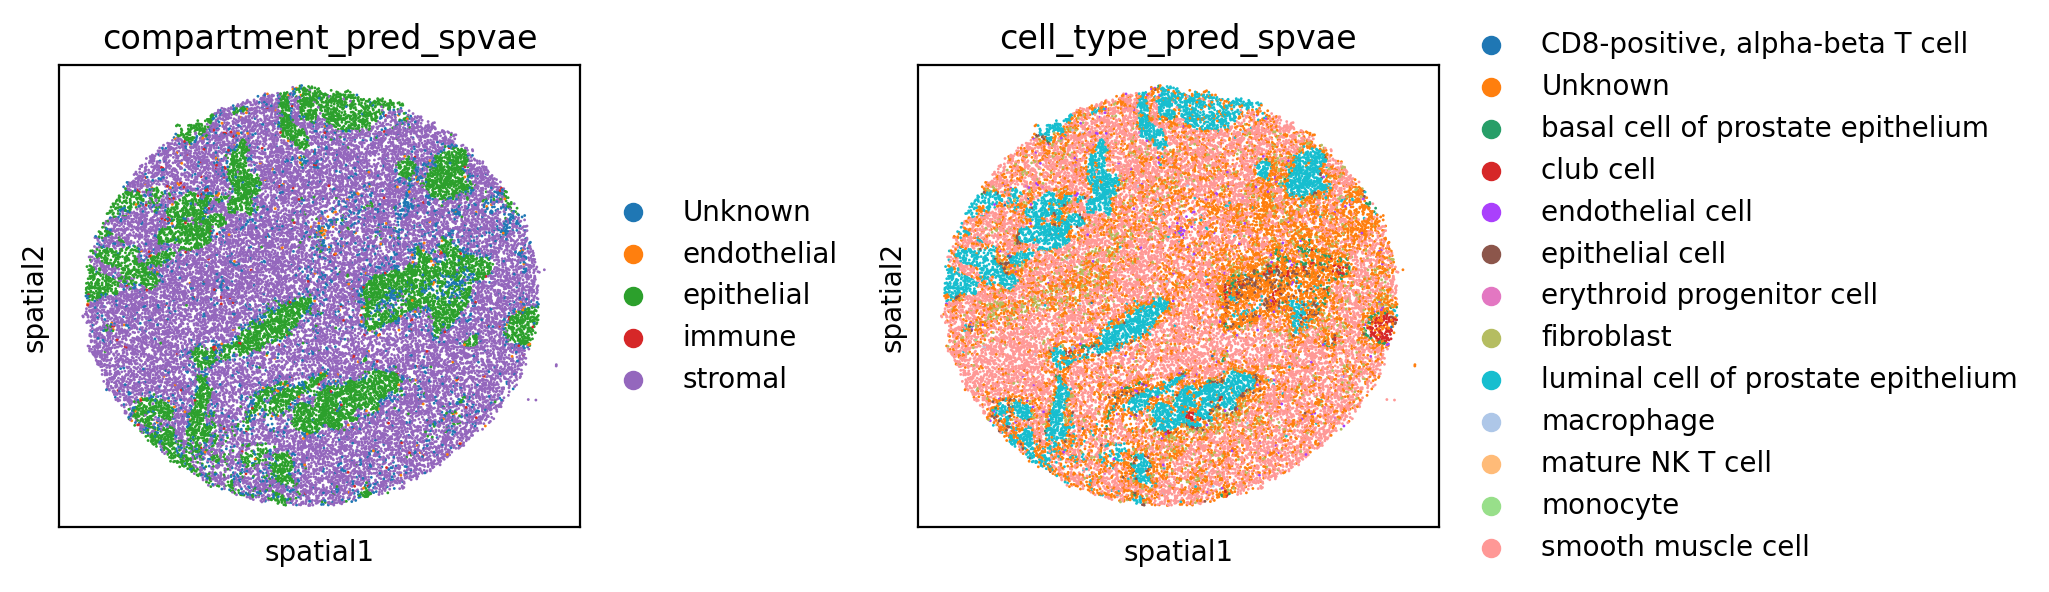

In [46]:
with plt.rc_context({"figure.figsize": (3, 3), 'savefig.bbox': 'tight'}):
    sc.pl.embedding(
        st, basis='spatial', 
        color=['compartment_pred_spvae', 'cell_type_pred_spvae'], 
        ncols=2, wspace=0.5
    )